In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils import data
import heidel_utils
from importlib import reload # reload 
reload(heidel_utils)


<module 'heidel_utils' from '/Users/svenkerstjens/msc-thesis/MSc-thesis/heidel_utils.py'>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler

N = 400
n_assemblies = 4
epsilon =1
base_w = 1
w_scale = [10]
w = 1
ss = StandardScaler()
mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
mask = (mask* (base_w*w)) + base_w

W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
if w > 0.:
    W *= base_w
    W *= mask
W2 = (W != 0).astype(int)
W = W-1

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
W

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

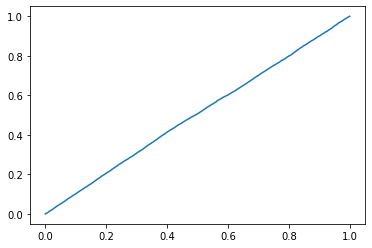

In [3]:
data = np.random.rand(10000)
x = np.sort(data)
y = np.arange(10000)/10000
plt.plot(x,y)

In [4]:
y

array([0.000e+00, 1.000e-04, 2.000e-04, ..., 9.997e-01, 9.998e-01,
       9.999e-01])

In [5]:
from collections import namedtuple
NeuronState = namedtuple('NeuronState', ['U', 'I', 'S'])

class LIFDensePopulation(nn.Module):
    # NeuronState = namedtuple('NeuronState', ['U', 'I', 'S'])
    def __init__(self, in_channels, out_channels, bias=True, alpha = .9, beta=.85, batch_size=10,W=None):
        super(LIFDensePopulation, self).__init__()
        self.fc_layer = nn.Linear(in_channels, out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_size = batch_size
        self.weight_scale = 0.2
        self.alpha = alpha
        self.beta = beta
        self.state = NeuronState(U=torch.zeros(batch_size, out_channels).to(device),
                                 I=torch.zeros(batch_size, out_channels).to(device),
                                 S=torch.zeros(batch_size, out_channels).to(device))
        self.NeuronState = self.state
        self.fc_layer.weight.data.normal_(mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))
        #torch.nn.init.normal_(self.fc_layer.weight.data, mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))
        self.fc_layer.bias.data.uniform_(-.01, .01)


    def forward(self, Sin_t):
        state = self.state
        U = self.alpha*state.U + state.I - state.S #mem
        I = self.beta*state.I + self.fc_layer(Sin_t) #syn
        # update the neuronal state
        S = smooth_step(U)
        self.state = NeuronState(U=U, I=I, S=S)
        self.NeuronState = self.state
        #state = NeuronState(U=U, I=I, S=S)
        return self.state

    def init_state(self):

        out_channels = self.out_channels
        self.state = NeuronState(U=torch.zeros(self.batch_size, out_channels,device=device),
                                 I=torch.zeros(self.batch_size, out_channels,device=device),
                                 S=torch.zeros(self.batch_size, out_channels,device=device))
        self.NeuronState = self.state

    def init_mod_weights(self,W):
        self.fc_layer.weight = torch.nn.Parameter(self.fc_layer.weight.data * torch.Tensor(W))

class LifRecPopulation(nn.Module):
    # NeuronState = namedtuple('NeuronState', ['U', 'I', 'S'])
    def __init__(self, in_channels, out_channels, bias=True, alpha = .9, beta=.85, batch_size=10,W=None):
        super(LifRecPopulation, self).__init__()
        self.fc_layer = nn.Linear(in_channels, out_channels)
        self.rec_layer = nn.Linear(out_channels, out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_size = batch_size
        self.weight_scale = 0.2
        self.alpha = alpha
        self.beta = beta
        self.state = NeuronState(U=torch.zeros(batch_size, out_channels).to(device),
                                 I=torch.zeros(batch_size, out_channels).to(device),
                                 S=torch.zeros(batch_size, out_channels).to(device))
        self.NeuronState = self.state
        #torch.nn.init.normal_(self.fc_layer.weight.data, mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))
        self.fc_layer.weight.data.normal_(mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))
        self.fc_layer.bias.data.uniform_(-.01, .01)
        #torch.nn.init.normal_(self.rec_layer.weight.data, mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))
        self.rec_layer.bias.data.uniform_(-.01, .01)
        self.rec_layer.weight.data.normal_(mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))


    def forward(self, Sin_t):
        state = self.state
        U = self.alpha*state.U + state.I - state.S #mem
        I = self.beta*state.I + self.fc_layer(Sin_t) + self.rec_layer(state.S) #syn
        # update the neuronal state
        S = smooth_step(U)
        self.state = NeuronState(U=U, I=I, S=S)
        self.NeuronState = self.state
        #state = NeuronState(U=U, I=I, S=S)
        return self.state

    def init_state(self):

        out_channels = self.out_channels
        self.state = NeuronState(U=torch.zeros(self.batch_size, out_channels,device=device),
                                 I=torch.zeros(self.batch_size, out_channels,device=device),
                                 S=torch.zeros(self.batch_size, out_channels,device=device))
        self.NeuronState = self.state

    def init_mod_weights(self,W):
        self.fc_layer.weight = torch.nn.Parameter(self.fc_layer.weight.data * torch.Tensor(W))


class SmoothStep(torch.autograd.Function):
    '''
    Modified from: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    '''

    scale = 100.0

    @staticmethod
    def forward(aux, x):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        aux.save_for_backward(x)
        out = torch.zeros_like(x)

        out[x > 0] = 1.0
        return out

    def backward(aux, grad_output):
        
        #grad_input = grad_output.clone()
        input, = aux.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SmoothStep.scale*torch.abs(input)+1.0)**2
        return grad


smooth_step = SmoothStep().apply

class OneHiddenModel(nn.Module):

    def __init__(self,in_channels,hidden_channels,out_channels,batch_size,alpha=.9,beta=.85,device='cpu',W=None):
        super(OneHiddenModel, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.device = device
        self.W = W
        self.layer1 = LIFDensePopulation(in_channels=self.in_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer2 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.out_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)

    def forward(self,Sin):
        hidden = self.layer1(Sin)
        out = self.layer2(hidden.S)
        return out

    def init_states(self):
        self.layer1.init_state()
        self.layer2.init_state()

    def init_mod_weights(self,W):
        self.layer1.fc_layer.weight = torch.nn.Parameter(self.layer1.fc_layer.weight.data * torch.Tensor(W))

class OneRecHiddenModel(nn.Module):

    def __init__(self,in_channels,hidden_channels,out_channels,batch_size,alpha=.9,beta=.85,device='cpu',W=None):
        super(OneRecHiddenModel, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.device = device
        self.W = W
        self.layer1 = LIFDensePopulation(in_channels=self.in_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer2 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer3 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.out_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)

    def forward(self,Sin):
        hidden1 = self.layer1(Sin)
        hidden2 = self.layer2(hidden1.S)
        out = self.layer3(hidden2.S)
        return out

    def init_states(self):
        self.layer1.init_state()
        self.layer2.init_state()
        self.layer3.init_state()

    def init_mod_weights(self,W):
        self.layer2.fc_layer.weight = torch.nn.Parameter((self.layer2.fc_layer.weight.data * W).to(torch.float32))

class ThreeHiddenModel(nn.Module):

    def __init__(self,in_channels,hidden_channels,out_channels,batch_size,alpha=.9,beta=.85,device='cpu',W=None):
        super(ThreeHiddenModel, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.device = device
        self.W = W
        self.layer1 = LIFDensePopulation(in_channels=self.in_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer2 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer3 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer4 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer5 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.out_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)

    def forward(self,Sin):
        hidden1 = self.layer1(Sin)
        hidden2 = self.layer2(hidden1.S)
        hidden3 = self.layer3(hidden2.S)
        hidden4 = self.layer4(hidden3.S)
        out = self.layer5(hidden4.S)
        return out

    def init_states(self):
        self.layer1.init_state()
        self.layer2.init_state()
        self.layer3.init_state()
        self.layer4.init_state()
        self.layer5.init_state()

    def init_mod_weights(self,W):
        self.layer1.fc_layer.weight = torch.nn.Parameter(self.layer1.fc_layer.weight.data * torch.Tensor(W))
        self.layer2.fc_layer.weight = torch.nn.Parameter(self.layer2.fc_layer.weight.data * torch.Tensor(W))
        self.layer3.fc_layer.weight = torch.nn.Parameter(self.layer3.fc_layer.weight.data * torch.Tensor(W))
        self.layer4.fc_layer.weight = torch.nn.Parameter(self.layer4.fc_layer.weight.data * torch.Tensor(W))


class FiveHiddenModel(nn.Module):

    def __init__(self,in_channels,hidden_channels,out_channels,batch_size,alpha=.9,beta=.85,device='cpu',W=None):
        super(FiveHiddenModel, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.device = device
        self.W = W
        self.layer1 = LIFDensePopulation(in_channels=self.in_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer2 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer3 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer4 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer5 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                        alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer6 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer7 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.out_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        #maybe try last layer non- spiking

    def forward(self,Sin):
        hidden1 = self.layer1(Sin)
        hidden2 = self.layer2(hidden1.S)
        hidden3 = self.layer3(hidden2.S)
        hidden4 = self.layer4(hidden3.S)
        hidden5 = self.layer5(hidden4.S)
        hidden6 = self.layer6(hidden5.S)
        out = self.layer7(hidden6.S)
        return out

    def init_states(self):
        self.layer1.init_state()
        self.layer2.init_state()
        self.layer3.init_state()
        self.layer4.init_state()
        self.layer5.init_state()
        self.layer6.init_state()
        self.layer7.init_state()

    def init_mod_weights(self,W):
        self.layer1.fc_layer.weight = torch.nn.Parameter(self.layer1.fc_layer.weight.data * W)
        self.layer2.fc_layer.weight = torch.nn.Parameter(self.layer2.fc_layer.weight.data * W)
        self.layer3.fc_layer.weight = torch.nn.Parameter(self.layer3.fc_layer.weight.data * W)
        self.layer4.fc_layer.weight = torch.nn.Parameter(self.layer4.fc_layer.weight.data * W)
        self.layer5.fc_layer.weight = torch.nn.Parameter(self.layer5.fc_layer.weight.data * W)
        self.layer6.fc_layer.weight = torch.nn.Parameter(self.layer6.fc_layer.weight.data * W)
class FiveRecHiddenModel(nn.Module):

    def __init__(self,in_channels,hidden_channels,out_channels,batch_size,alpha=.9,beta=.85,device='cpu',W=None):
        super(FiveRecHiddenModel, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.device = device
        self.W = W
        self.layer1 = LIFDensePopulation(in_channels=self.in_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer2 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer3 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer4 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer5 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                        alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer6 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer7 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.out_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        #maybe try last layer non- spiking

    def forward(self,Sin):
        hidden1 = self.layer1(Sin)
        hidden2 = self.layer2(hidden1.S)
        hidden3 = self.layer3(hidden2.S)
        hidden4 = self.layer4(hidden3.S)
        hidden5 = self.layer5(hidden4.S)
        hidden6 = self.layer6(hidden5.S)
        out = self.layer7(hidden6.S)
        return out

    def init_states(self):
        self.layer1.init_state()
        self.layer2.init_state()
        self.layer3.init_state()
        self.layer4.init_state()
        self.layer5.init_state()
        self.layer6.init_state()
        self.layer7.init_state()

    def init_mod_weights(self,W):
        #self.layer1.fc_layer.weight = torch.nn.Parameter(self.layer1.fc_layer.weight.data * torch.Tensor(W))
        self.layer2.fc_layer.weight = torch.nn.Parameter((self.layer2.fc_layer.weight.data * W).to(torch.float32))
        self.layer3.fc_layer.weight = torch.nn.Parameter((self.layer3.fc_layer.weight.data * W).to(torch.float32))
        self.layer4.fc_layer.weight = torch.nn.Parameter((self.layer4.fc_layer.weight.data * W).to(torch.float32))
        self.layer5.fc_layer.weight = torch.nn.Parameter((self.layer5.fc_layer.weight.data * W).to(torch.float32))
        #self.layer6.fc_layer.weight = torch.nn.Parameter(self.layer6.fc_layer.weight.data * torch.Tensor(W))

class TwoRecHiddenModel(nn.Module):

    def __init__(self,in_channels,hidden_channels,out_channels,batch_size,alpha=.9,beta=.85,device='cpu',W=None):
        super(TwoRecHiddenModel, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.device = device
        self.W = W
        self.layer1 = LIFDensePopulation(in_channels=self.in_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size,W=W).to(device)
        self.layer2 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer3 = LifRecPopulation(in_channels=self.hidden_channels,out_channels=self.hidden_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        self.layer4 = LIFDensePopulation(in_channels=self.hidden_channels,out_channels=self.out_channels,
                                         alpha=self.alpha,beta=self.beta,batch_size=self.batch_size).to(device)
        #maybe try last layer non- spiking

    def forward(self,Sin):
        hidden1 = self.layer1(Sin)
        hidden2 = self.layer2(hidden1.S)
        hidden3 = self.layer3(hidden2.S)
        out = self.layer4(hidden3.S)
        return out

    def init_states(self):
        self.layer1.init_state()
        self.layer2.init_state()
        self.layer3.init_state()
        self.layer4.init_state()

    def init_mod_weights(self,W):
        #self.layer1.fc_layer.weight = torch.nn.Parameter(self.layer1.fc_layer.weight.data * torch.Tensor(W))
        self.layer2.fc_layer.weight = torch.nn.Parameter((self.layer2.fc_layer.weight.data * W).to(torch.float32))
        #self.layer6.fc_layer.weight = torch.nn.Parameter(self.layer6.fc_layer.weight.data * torch.Tensor(W))



In [6]:
nb_inputs  = 700
nb_hidden  = 400
nb_outputs = 20

time_step = 1e-3
nb_steps = 100
max_time = 1.4

batch_size = 256
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cpu


In [7]:
# Here we load the Dataset
cache_dir = os.path.expanduser("~/data")
cache_subdir = "hdspikes"
heidel_utils.get_shd_dataset(cache_dir, cache_subdir)

train_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
test_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

Available at: /Users/svenkerstjens/data/hdspikes/shd_train.h5
Available at: /Users/svenkerstjens/data/hdspikes/shd_test.h5


In [9]:
model = FiveRecHiddenModel(in_channels=nb_inputs,hidden_channels=400,out_channels=nb_outputs,batch_size=batch_size,W=None).to(device)

In [14]:
model.state_dict

<bound method Module.state_dict of FiveRecHiddenModel(
  (layer1): LIFDensePopulation(
    (fc_layer): Linear(in_features=700, out_features=400, bias=True)
  )
  (layer2): LifRecPopulation(
    (fc_layer): Linear(in_features=400, out_features=400, bias=True)
    (rec_layer): Linear(in_features=400, out_features=400, bias=True)
  )
  (layer3): LifRecPopulation(
    (fc_layer): Linear(in_features=400, out_features=400, bias=True)
    (rec_layer): Linear(in_features=400, out_features=400, bias=True)
  )
  (layer4): LifRecPopulation(
    (fc_layer): Linear(in_features=400, out_features=400, bias=True)
    (rec_layer): Linear(in_features=400, out_features=400, bias=True)
  )
  (layer5): LifRecPopulation(
    (fc_layer): Linear(in_features=400, out_features=400, bias=True)
    (rec_layer): Linear(in_features=400, out_features=400, bias=True)
  )
  (layer6): LifRecPopulation(
    (fc_layer): Linear(in_features=400, out_features=400, bias=True)
    (rec_layer): Linear(in_features=400, out_feat

In [91]:
in_size = 700
hid_size_W = 344
hid_size_OG = 200
out_size = 20
hidden_layers = 5

In [102]:
param_count_OG = in_size * hid_size_OG + (hidden_layers * 2 * hid_size_OG * hid_size_OG) + (out_size * hid_size_OG)
param_count_W = in_size * hid_size_W + (hidden_layers * 2 * hid_size_W * hid_size_W)/4 + (out_size * hid_size_W)
print(f'OG: {param_count_OG}')
print(f'W: {param_count_W}')

hid_size_W

def find_hidden_size(layers,blocks,in_size=700,out_size=20,params_to_match=544000):
    a = layers * 2 / blocks
    b = in_size + out_size
    c = -params_to_match
    d = b ** 2 - (4 * a * c)
    x1 = round((-b - np.sqrt(d))/ ( 2 * a))
    x2 = round((-b + np.sqrt(d))/ ( 2 * a))
    if x1 > 0:
        param_count_OG = params_to_match
        param_count_W = b * x1 + (a * x1 * x1) 


        print(f'Original #parameters: {param_count_OG}')
        print(f'Augmented #parameters: {param_count_W}')
        return x1
    else:
        param_count_OG = params_to_match
        param_count_W = b * x2 + (a * x2 * x2) 


        print(f'Original #parameters: {param_count_OG}')
        print(f'Augmented #parameters: {param_count_W}')
        return x2
    


hidden_size = find_hidden_size(layers=5,blocks=4)


OG: 544000
W: 543520.0
Original #parameters: 544000
Augmented #parameters: 543520.0


In [103]:
hidden_size

344

In [8]:
def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors.

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(labels_)//batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']

    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]

            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)

        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [17]:
W = torch.tensor(W,device=device)

In [34]:
model = OneRecHiddenModel(in_channels=nb_inputs,hidden_channels=400,out_channels=nb_outputs,batch_size=batch_size,W=W).to(device)

In [22]:
import time

model = OneRecHiddenModel(in_channels=nb_inputs,hidden_channels=400,out_channels=nb_outputs,batch_size=batch_size,W=W).to(device)

ce_loss = torch.nn.CrossEntropyLoss().to(device)
#copy_w = model.layer2.fc_layer.weight.data.clone()
#plt.imshow(copy_w.cpu())
model.init_mod_weights(W)
#copy_w = model.layer2.fc_layer.weight.data.clone()
#plt.imshow(copy_w.cpu())

params = model.parameters()
opt = torch.optim.Adamax(params, lr=2e-4, betas=(0.9,0.999)) #lr is the learning rate
#decay = .9

epochs = 100
loss_hist = []
for epoch in range(epochs):
    tic = time.time()
    avg_loss = 0
    model.train()
    sum_acc=0
    count = 0
    local_loss = []
    #batches
    for x,y in sparse_data_generator_from_hdf5_spikes(x_train, y_train, batch_size, nb_steps, nb_units=nb_inputs, max_time=max_time, shuffle=True):
        
        model.init_states()

        #Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
        out = torch.zeros((batch_size,model.out_channels),device=device)
        out_rec = [out]
        #timesteps
        for n in range(nb_steps):
            out_state = model(x.to_dense()[:,n])
            out_rec.append(out_state.U)
            #add decay for leakiness
            #collect spikes over time
            #Sprobe = decay * Sprobe + out_state.S
        out_rec = torch.stack(out_rec,dim=1)
        prediction = torch.max(out_rec,1).values

        #prediction = Sprobe
        #if i==0:
        #    print(prediction)

        #accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])

        #class labels only
        loss = ce_loss(prediction,y)


        #tonic & torch neuromorphic

        loss.backward()
        opt.step()
        opt.zero_grad()
        model.init_mod_weights(W)
        #model.init_mod_weights(W2)
        #sum_acc = sum_acc + accuracy
        #sum_loss = sum_loss + loss
        avg_loss = ((avg_loss * count) + loss)/(count+1)
        count += 1
        local_loss.append(loss.item())
    mean_loss = np.mean(local_loss)
    loss_hist.append(mean_loss)
    #avg_train_acc = sum_acc/(len(train_batch_ids))
    #avg_loss = sum_loss/(len(train_batch_ids))
    #if i == 3:/'
    #loss_hist = loss_hist + [float(avg_loss)]
    #acc_hist = acc_hist + [float(avg_train_acc)]

    toc = time.time()
    print(f'time for epoch {epoch}: {toc-tic}')
    if epoch%1==0:
        print(f'epoch {epoch}: \n loss: {mean_loss}')
        #print(f'train_acc: {avg_train_acc}')
    #val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
    #val_acc_hist = val_acc_hist + [val_acc]
    #print(f'val_acc: {val_acc}')



/tmp/ipykernel_607316/915459707.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y,dtype=np.int)


time for epoch 0: 16.801953077316284
epoch 0: 
 loss: 2.9226753096426688
time for epoch 1: 16.850791215896606
epoch 1: 
 loss: 2.5799513555342153
time for epoch 2: 16.847952365875244
epoch 2: 
 loss: 2.18308344194966
time for epoch 3: 16.952245950698853
epoch 3: 
 loss: 2.042382409495692
time for epoch 4: 16.673739194869995
epoch 4: 
 loss: 1.7209171056747437
time for epoch 5: 16.508342027664185
epoch 5: 
 loss: 1.5946291108285227
time for epoch 6: 16.589630126953125
epoch 6: 
 loss: 1.5006556972380607
time for epoch 7: 16.525896549224854
epoch 7: 
 loss: 1.425109624862671
time for epoch 8: 16.5381019115448
epoch 8: 
 loss: 1.415995063320283
time for epoch 9: 16.53945755958557
epoch 9: 
 loss: 1.3672551339672459
time for epoch 10: 16.63845205307007
epoch 10: 
 loss: 1.3038523004901024
time for epoch 11: 16.512351036071777
epoch 11: 
 loss: 1.2349241087513585
time for epoch 12: 16.50662899017334
epoch 12: 
 loss: 1.3051669905262608
time for epoch 13: 16.51133942604065
epoch 13: 
 loss: 

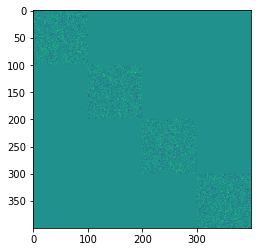

In [30]:
wplot = model.layer2.fc_layer.weight.data.clone()
plt.imshow(wplot.detach().cpu().numpy())

In [24]:
def batch_accuracy(prediction,y):
    return (np.argmax(prediction.detach().cpu().numpy(),axis=1) == y.cpu().numpy()).sum()/256*100

In [41]:
model = OneRecHiddenModel(in_channels=nb_inputs,hidden_channels=nb_hidden,out_channels=nb_outputs,batch_size=batch_size,W=None).to(device)

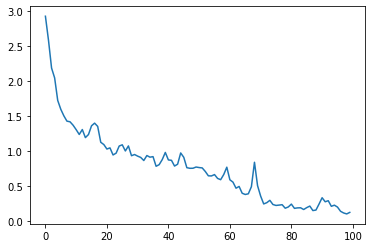

In [26]:
plt.plot(loss_hist)

In [25]:
#torch.save(model.state_dict(), '5_rec_test.pth')
#model = FiveRecHiddenModel(in_channels=nb_inputs,hidden_channels=200,out_channels=nb_outputs,batch_size=batch_size,W=None).to(device)
#model.load_state_dict(torch.load('5_rec_test.pth'))

counter = 0
overall_accuracy = 0
for x,y in sparse_data_generator_from_hdf5_spikes(x_test, y_test, batch_size, nb_steps, nb_units=nb_inputs, max_time=max_time, shuffle=True):
        model.eval()
        model.init_states()

        #Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
        out = torch.zeros((batch_size,model.out_channels),device=device)
        out_rec = [out]
        #timesteps
        for n in range(nb_steps):
            out_state = model(x.to_dense()[:,n])
            out_rec.append(out_state.U)
            #add decay for leakiness
            #collect spikes over time
            #Sprobe = decay * Sprobe + out_state.S
        out_rec = torch.stack(out_rec,dim=1)
        prediction = torch.max(out_rec,1).values

        batch_acc = batch_accuracy(prediction,y)
        overall_accuracy = ((overall_accuracy * counter) + batch_acc) / (counter + 1)
        counter +=1
        print('overall accuracy: {:.4}%'.format(overall_accuracy))
        

        

/tmp/ipykernel_607316/915459707.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y,dtype=np.int)


overall accuracy: 73.44%
overall accuracy: 73.83%
overall accuracy: 73.18%
overall accuracy: 73.44%
overall accuracy: 73.98%
overall accuracy: 73.89%
overall accuracy: 74.55%
overall accuracy: 75.0%


AttributeError: 'list' object has no attribute 'shape'